In [2]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv(r'C:\Users\chakr\OneDrive\Desktop\ml\gluco\diabetes.csv')

# Replace zeros with NaN for key columns
columns_to_fix = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[columns_to_fix] = df[columns_to_fix].replace(0, np.nan)

# Fill missing values with median
df.fillna(df.median(), inplace=True)
df


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63,0
764,2,122.0,70.0,27.0,125.0,36.8,0.340,27,0
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30,0
766,1,126.0,60.0,29.0,125.0,30.1,0.349,47,1


In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Normalize features
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Recursive Feature Elimination
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=6)
X_selected = X_scaled.loc[:, rfe.fit(X_scaled, y).get_support()]


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_selected, y) # type: ignore

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [5]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)
gb.fit(X_train, y_train)


GradientBoostingClassifier(random_state=42)

In [6]:
import numpy as np

def ensemble_predict(X):
    rf_probs = rf.predict_proba(X)
    gb_probs = gb.predict_proba(X)
    avg_probs = (0.6 * rf_probs + 0.4 * gb_probs)
    return np.argmax(avg_probs, axis=1)


In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = ensemble_predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc:.2f}")
print(f"Precision: {prec:.2f}")     
print(f"Recall: {rec:.2f}")
print(f"F1 Score: {f1:.2f}")        

Accuracy: 0.81
Precision: 0.78
Recall: 0.86
F1 Score: 0.82


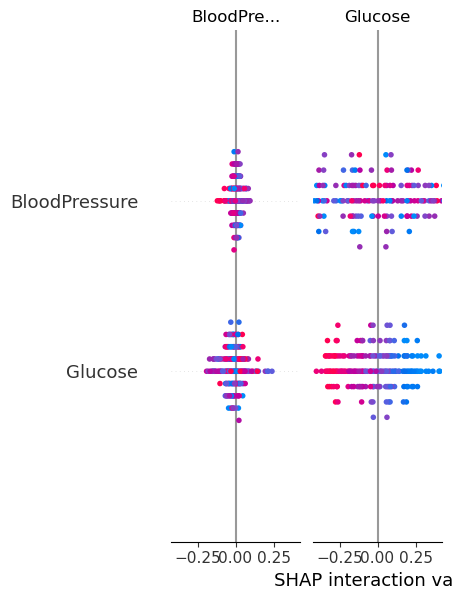

In [15]:

import shap # type: ignore

explainer = shap.Explainer(rf, X_train)
shap_values = explainer(X_test, check_additivity=False)
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10)


In [26]:
# Sample test patient from dataset
# Use median for Insulin as in preprocessing
insulin_median = df['Insulin'].median()
sample_input = {
    'Glucose': 148,
    'BloodPressure': 72,
    'Insulin': df['Insulin'].median(),
    'BMI': 33.6,
    'DiabetesPedigreeFunction': 0.627,
    'Age': 50
}

# Convert to DataFrame
sample_df = pd.DataFrame([sample_input])

# Reindex to match the scaler's expected columns (all columns used in fit)
sample_df_full = sample_df.reindex(columns=X.columns, fill_value=0)
sample_df_full_scaled = scaler.transform(sample_df_full)

# Select only the features used for prediction (same as X_selected.columns)
sample_df_selected_scaled = pd.DataFrame(sample_df_full_scaled, columns=X.columns)[X_selected.columns]

# Predict
sample_prediction = ensemble_predict(sample_df_selected_scaled)[0]

# Output
print("🔍 Sample Test Result:")
print("Prediction:", "Non-Diabetic 🟢" if sample_prediction == 0 else "Diabetic 🔴")


🔍 Sample Test Result:
Prediction: Diabetic 🔴


In [28]:

sample_input = {
    'Pregnancies': 1,
    'Glucose': 85,
    'BloodPressure': 66,
    'SkinThickness': 29,
    'Insulin': df['Insulin'].median(),  # If you imputed 0s, replace with df['Insulin'].median()
    'BMI': 26.6,
    'DiabetesPedigreeFunction': 0.351,
    'Age': 31
}


sample_df = pd.DataFrame([sample_input])

# Reindex to match the scaler's expected columns (all columns used in fit)
sample_df_full = sample_df.reindex(columns=X.columns, fill_value=0)
sample_df_full_scaled = scaler.transform(sample_df_full)

# Select only the features used for prediction (same as X_selected.columns)
sample_df_selected_scaled = pd.DataFrame(sample_df_full_scaled, columns=X.columns)[X_selected.columns]

# Predict
sample_prediction = ensemble_predict(sample_df_selected_scaled)[0]
print(sample_prediction)
# Output
print("🔍 Sample Test Result:")
print("Prediction:", "Non-Diabetic 🟢" if sample_prediction == 0 else "Diabetic 🔴")


0
🔍 Sample Test Result:
Prediction: Non-Diabetic 🟢


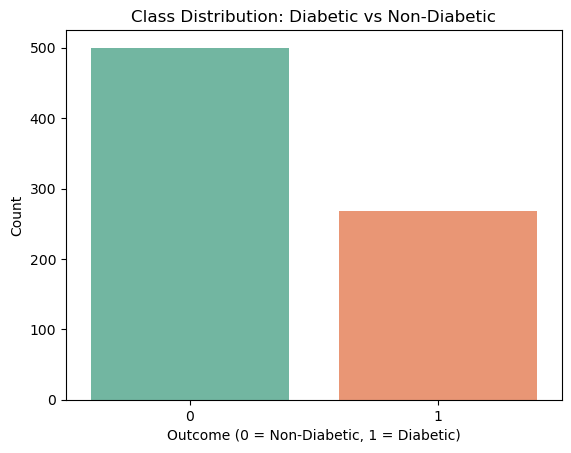

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Outcome', data=df, palette='Set2')
plt.title("Class Distribution: Diabetic vs Non-Diabetic")
plt.xlabel("Outcome (0 = Non-Diabetic, 1 = Diabetic)")
plt.ylabel("Count")
plt.show()


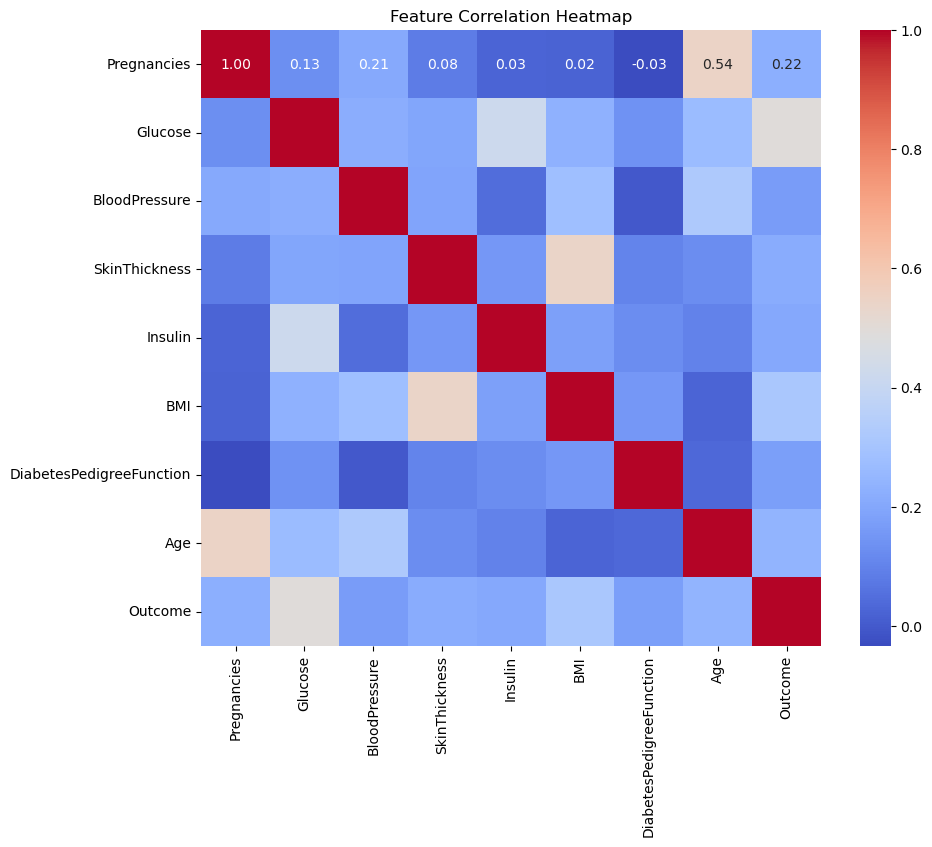

In [30]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


C:\Users\chakr\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\chakr\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\chakr\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


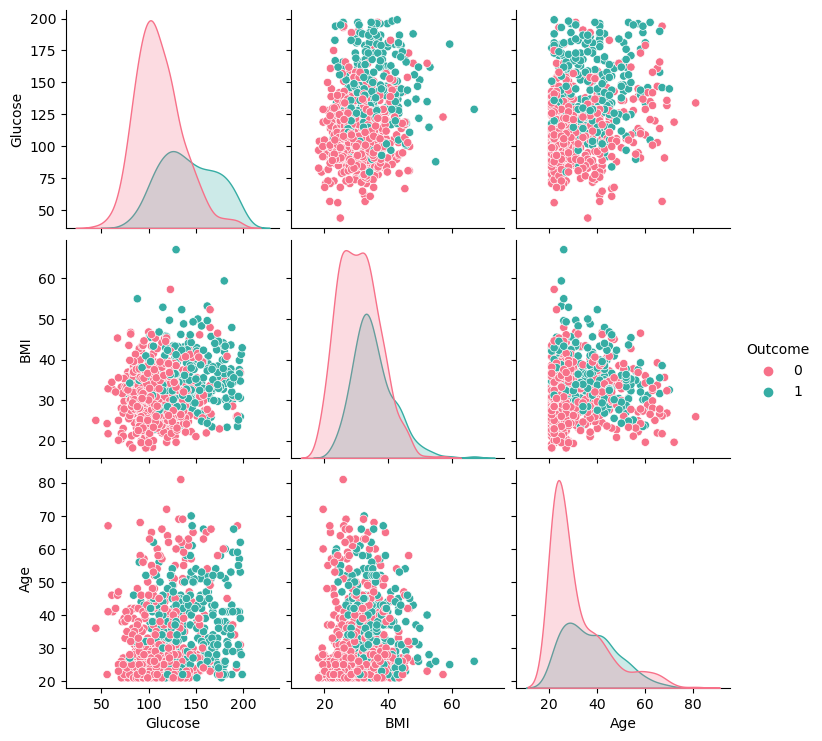

In [31]:
selected_cols = ['Glucose', 'BMI', 'Age', 'Outcome']
sns.pairplot(df[selected_cols], hue="Outcome", palette="husl")
plt.show()


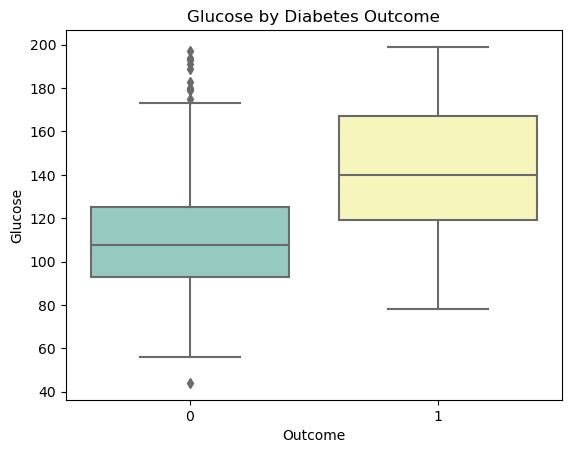

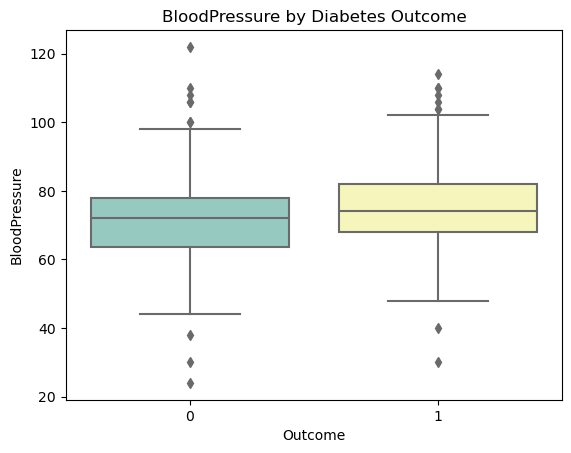

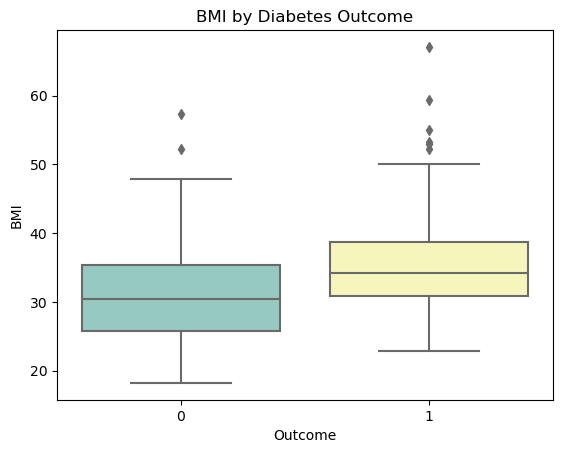

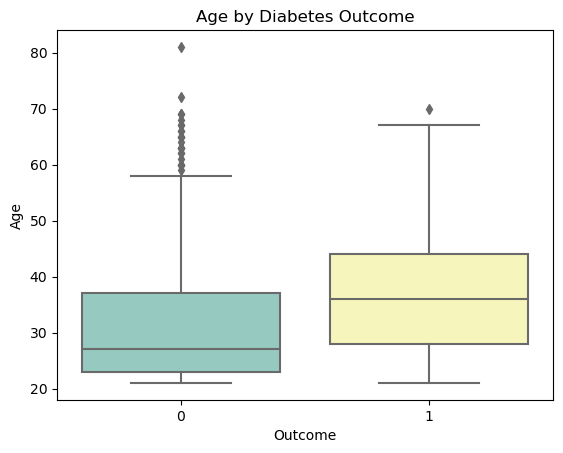

In [32]:
features = ['Glucose', 'BloodPressure', 'BMI', 'Age']
for feature in features:
    plt.figure()
    sns.boxplot(x='Outcome', y=feature, data=df, palette='Set3')
    plt.title(f"{feature} by Diabetes Outcome")
    plt.show()


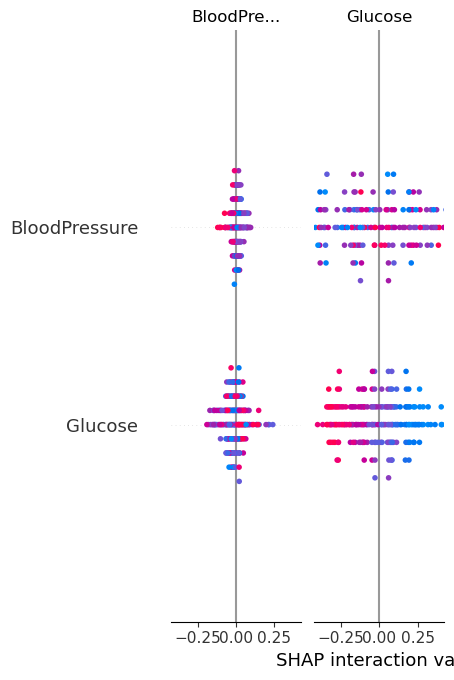

In [ ]:
import shap # type: ignore

explainer = shap.Explainer(rf, X_train)
shap_values = explainer(X_test, check_additivity=False)

# Global feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar")
